In [1]:
import GPy
import GPyOpt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


You’ve reach the final, 8-dimensional search space. High-dimensional black-box optimisation can be very difficult, so sticking to local solutions is not the worst idea here.

In [2]:
def load_initial_data(inputs_file, outputs_file) -> pd.DataFrame:
    X = np.load(inputs_file)
    y = np.load(outputs_file)
    df = pd.DataFrame(X, columns=['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8'])
    df['y'] = y
    return df

df1 = load_initial_data(
    '../initial_data/function_8/initial_inputs.npy',
    '../initial_data/function_8/initial_outputs.npy',
)
df2 = load_initial_data(
    '../initial_data2/function_8/initial_inputs.npy',
    '../initial_data2/function_8/initial_outputs.npy',
)

df = pd.concat([df1, df2], ignore_index=True)

df.head()


x1        x2        x3        x4        x5        x6        x7  \
0  0.604994  0.292215  0.908453  0.355506  0.201669  0.575338  0.310311   
1  0.178007  0.566223  0.994862  0.210325  0.320153  0.707909  0.635384   
2  0.009077  0.811626  0.520520  0.075687  0.265112  0.091652  0.592415   
3  0.506028  0.653730  0.363411  0.177981  0.093728  0.197425  0.755827   
4  0.359909  0.249076  0.495997  0.709215  0.114987  0.289207  0.557295   

         x8         y  
0  0.734281  7.398721  
1  0.107132  7.005227  
2  0.367320  8.459482  
3  0.292472  8.284008  
4  0.593882  8.606117

In [3]:
import re

df_feedback = pd.read_csv('../initial_data/561_data.csv')

df_feedback = df_feedback[['f8', 'f8_output']]
df_feedback['f8'] = df_feedback['f8'].apply(lambda x: re.findall(r'\d+\.\d*', x))

for i in range(len(df_feedback['f8'].iloc[0])):
    df_feedback[f'x{i+1}'] = df_feedback['f8'].apply(lambda x: float(x[i]))

df_feedback.drop('f8', axis=1, inplace=True)
df_feedback = df_feedback.rename(columns={'f8_output': 'y'})
df_feedback = df_feedback[['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'y']]

df = pd.concat([df, df_feedback], ignore_index=True)
df.describe()

x1         x2         x3         x4         x5         x6  \
count  87.000000  87.000000  87.000000  87.000000  87.000000  87.000000   
mean    0.526608   0.501454   0.538883   0.473658   0.455097   0.488848   
std     0.316035   0.326395   0.300494   0.288642   0.297828   0.306818   
min     0.005540   0.003419   0.000848   0.009043   0.000000   0.000000   
25%     0.238150   0.193527   0.320668   0.186747   0.187791   0.235465   
50%     0.532820   0.566223   0.495997   0.497396   0.444922   0.479253   
75%     0.797785   0.799215   0.812799   0.691996   0.714852   0.757198   
max     0.999999   0.999999   0.999999   0.999999   0.994765   0.999354   

              x7         x8          y  
count  87.000000  87.000000  87.000000  
mean    0.622904   0.488919   7.548169  
std     0.267321   0.291555   1.403318  
min     0.003214   0.016518   2.798315  
25%     0.407474   0.252533   6.877529  
50%     0.651115   0.477506   7.854541  
75%     0.833632   0.730382   8.559069  
max     0.999999   0.999999   9.755085

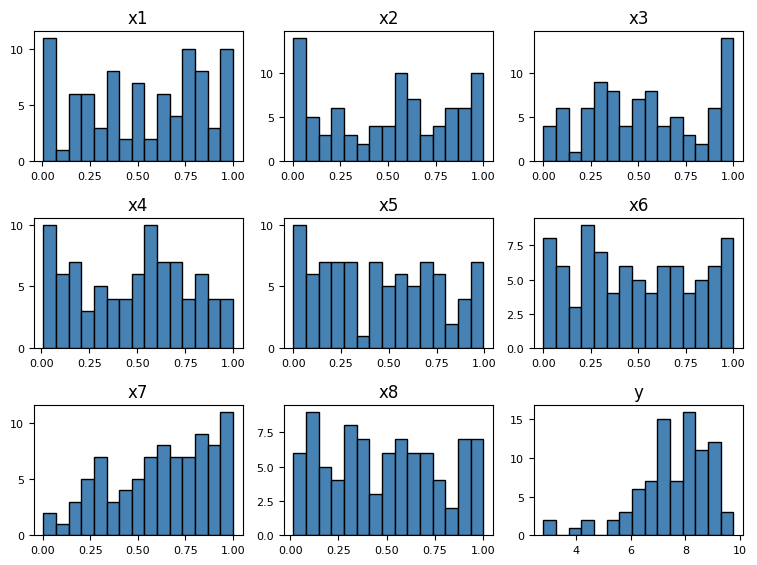

In [4]:
df.hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0, xlabelsize=8, ylabelsize=8, grid=False)
plt.tight_layout(rect=(0, 0, 1.2, 1.2))

In [5]:
def analyse_param(df, x, y):
    fig, axes = plt.subplots(1, 3, figsize=(12, 3))

    # Plot histogram
    axes[0].set_xlabel(x)
    axes[0].set_ylabel("Frequency")
    axes[0].hist(df[x], bins=15, color='steelblue', edgecolor='black', linewidth=1.0)

    # Plot density
    axes[1].set_xlabel(x)
    axes[1].set_ylabel("Frequency")
    sns.kdeplot(df[x], ax=axes[1], color='steelblue', shade=True, legend=False)

    # Plot scatter
    axes[2].set_xlabel(x)
    axes[2].set_ylabel(y)
    axes[2].scatter(df[x], df[y], s=30, edgecolor='black', alpha=0.7)

    plt.tight_layout()
    plt.show()


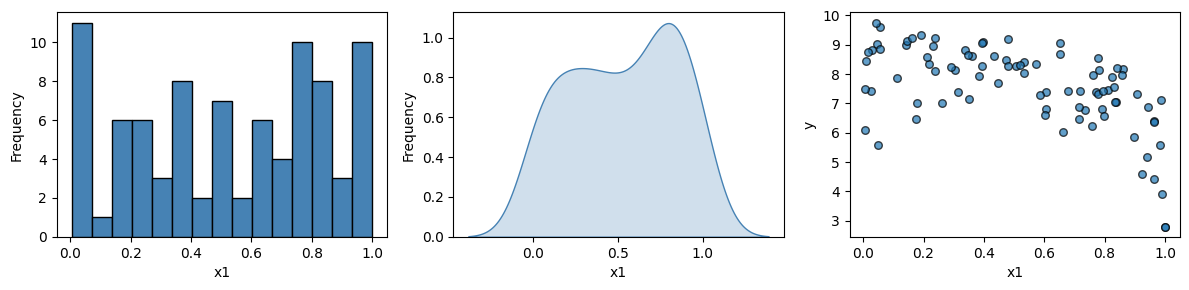

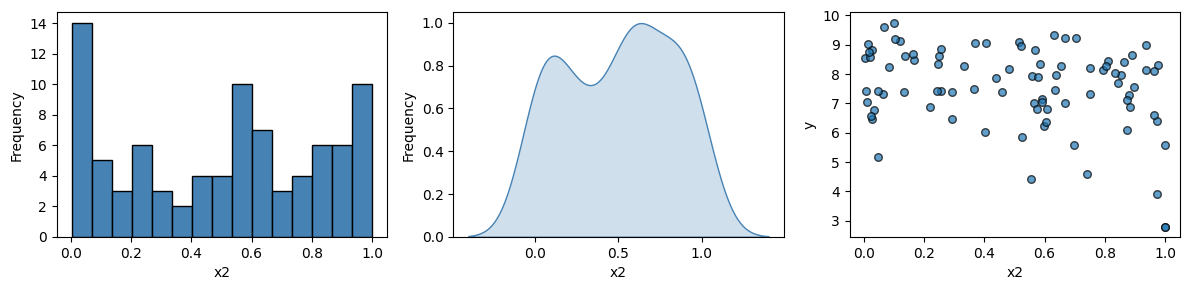

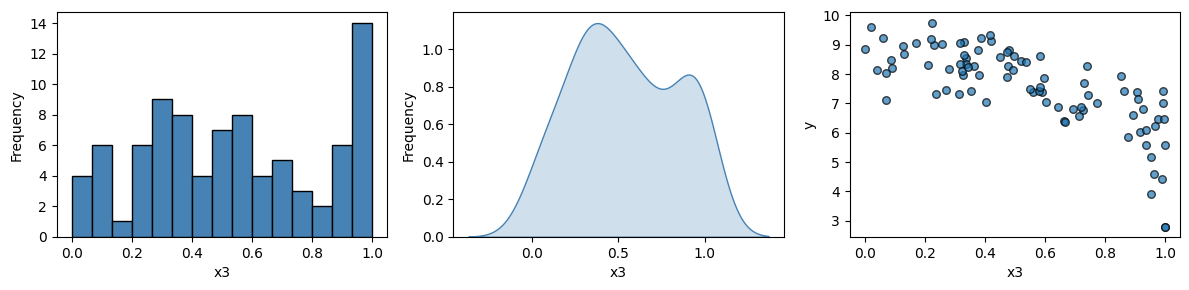

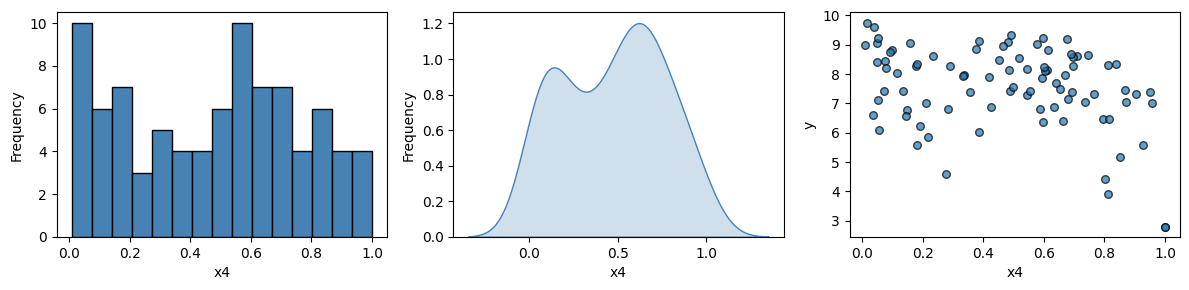

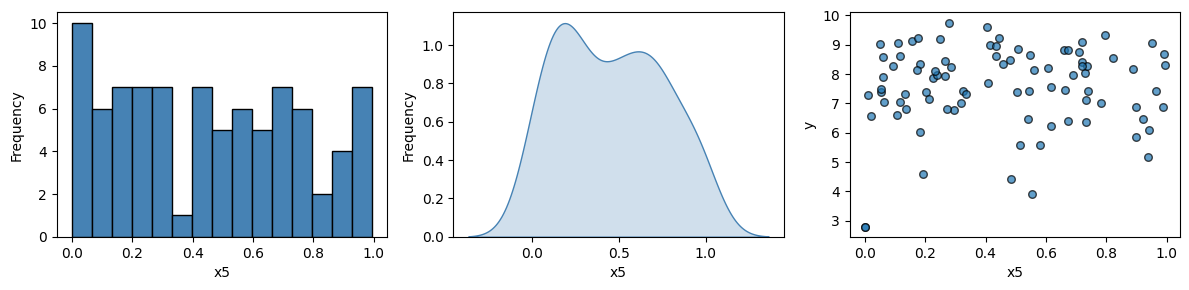

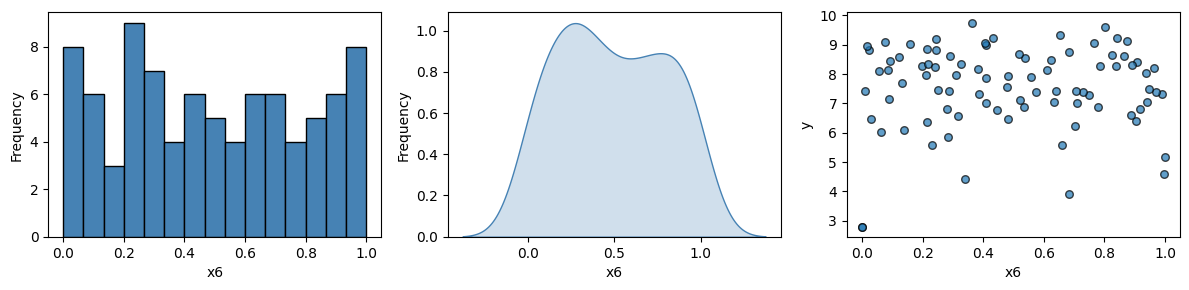

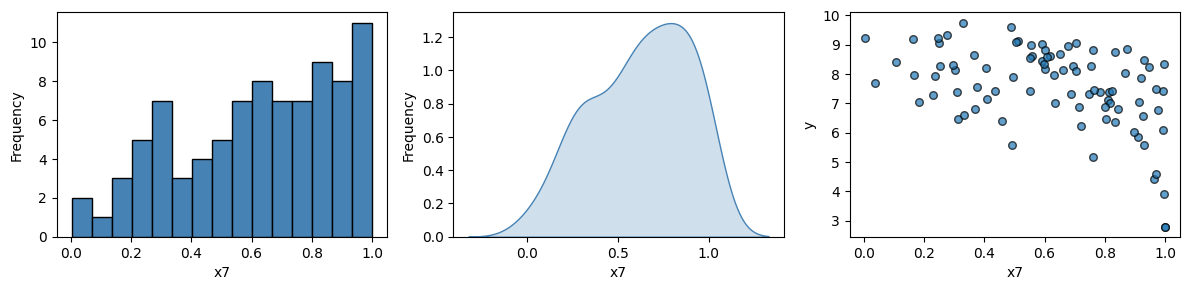

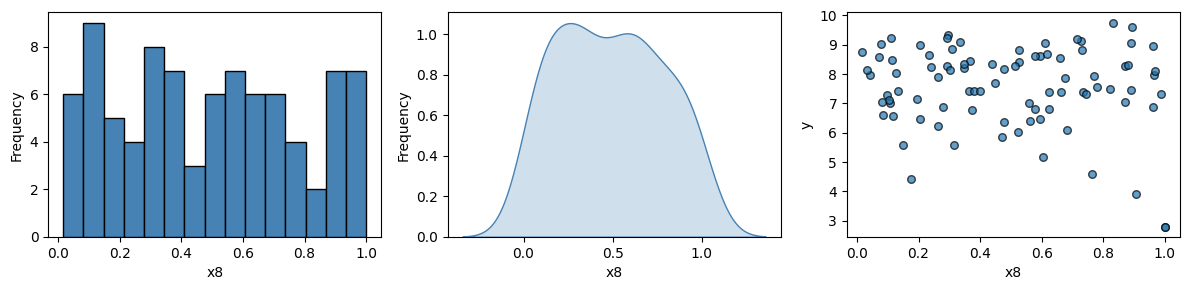

In [6]:
analyse_param(df, 'x1', 'y')
analyse_param(df, 'x2', 'y')
analyse_param(df, 'x3', 'y')
analyse_param(df, 'x4', 'y')
analyse_param(df, 'x5', 'y')
analyse_param(df, 'x6', 'y')
analyse_param(df, 'x7', 'y')
analyse_param(df, 'x8', 'y')


In [7]:
def analyse_corr_to_y(df):
    # Plot correlation to y
    corr = df.corr()
    sns.heatmap(corr[['y']], annot=True, cmap='coolwarm')

    # Analyse correlation of variables to y
    g = sns.PairGrid(df, y_vars=["y"], x_vars=["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8"])
    g.map(sns.regplot, color='steelblue')

    plt.tight_layout()
    plt.show()

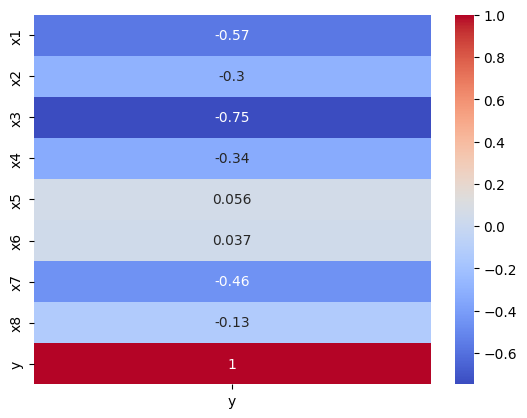

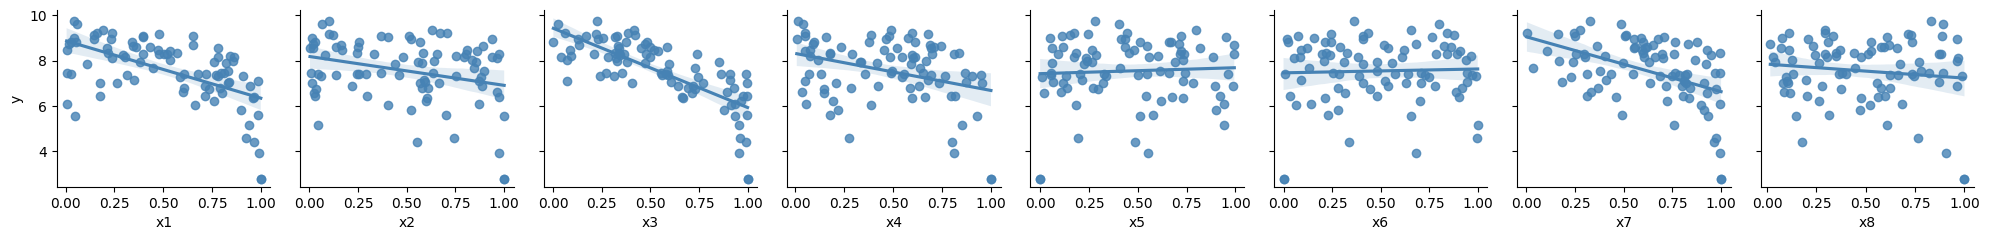

In [8]:
analyse_corr_to_y(df)

In [9]:
def pairwise_relationship(df):
    sns.pairplot(df, kind='scatter', diag_kind='kde', plot_kws={'alpha': 0.7, 's': 30, 'edgecolor': 'black'})
    plt.tight_layout()
    plt.show()

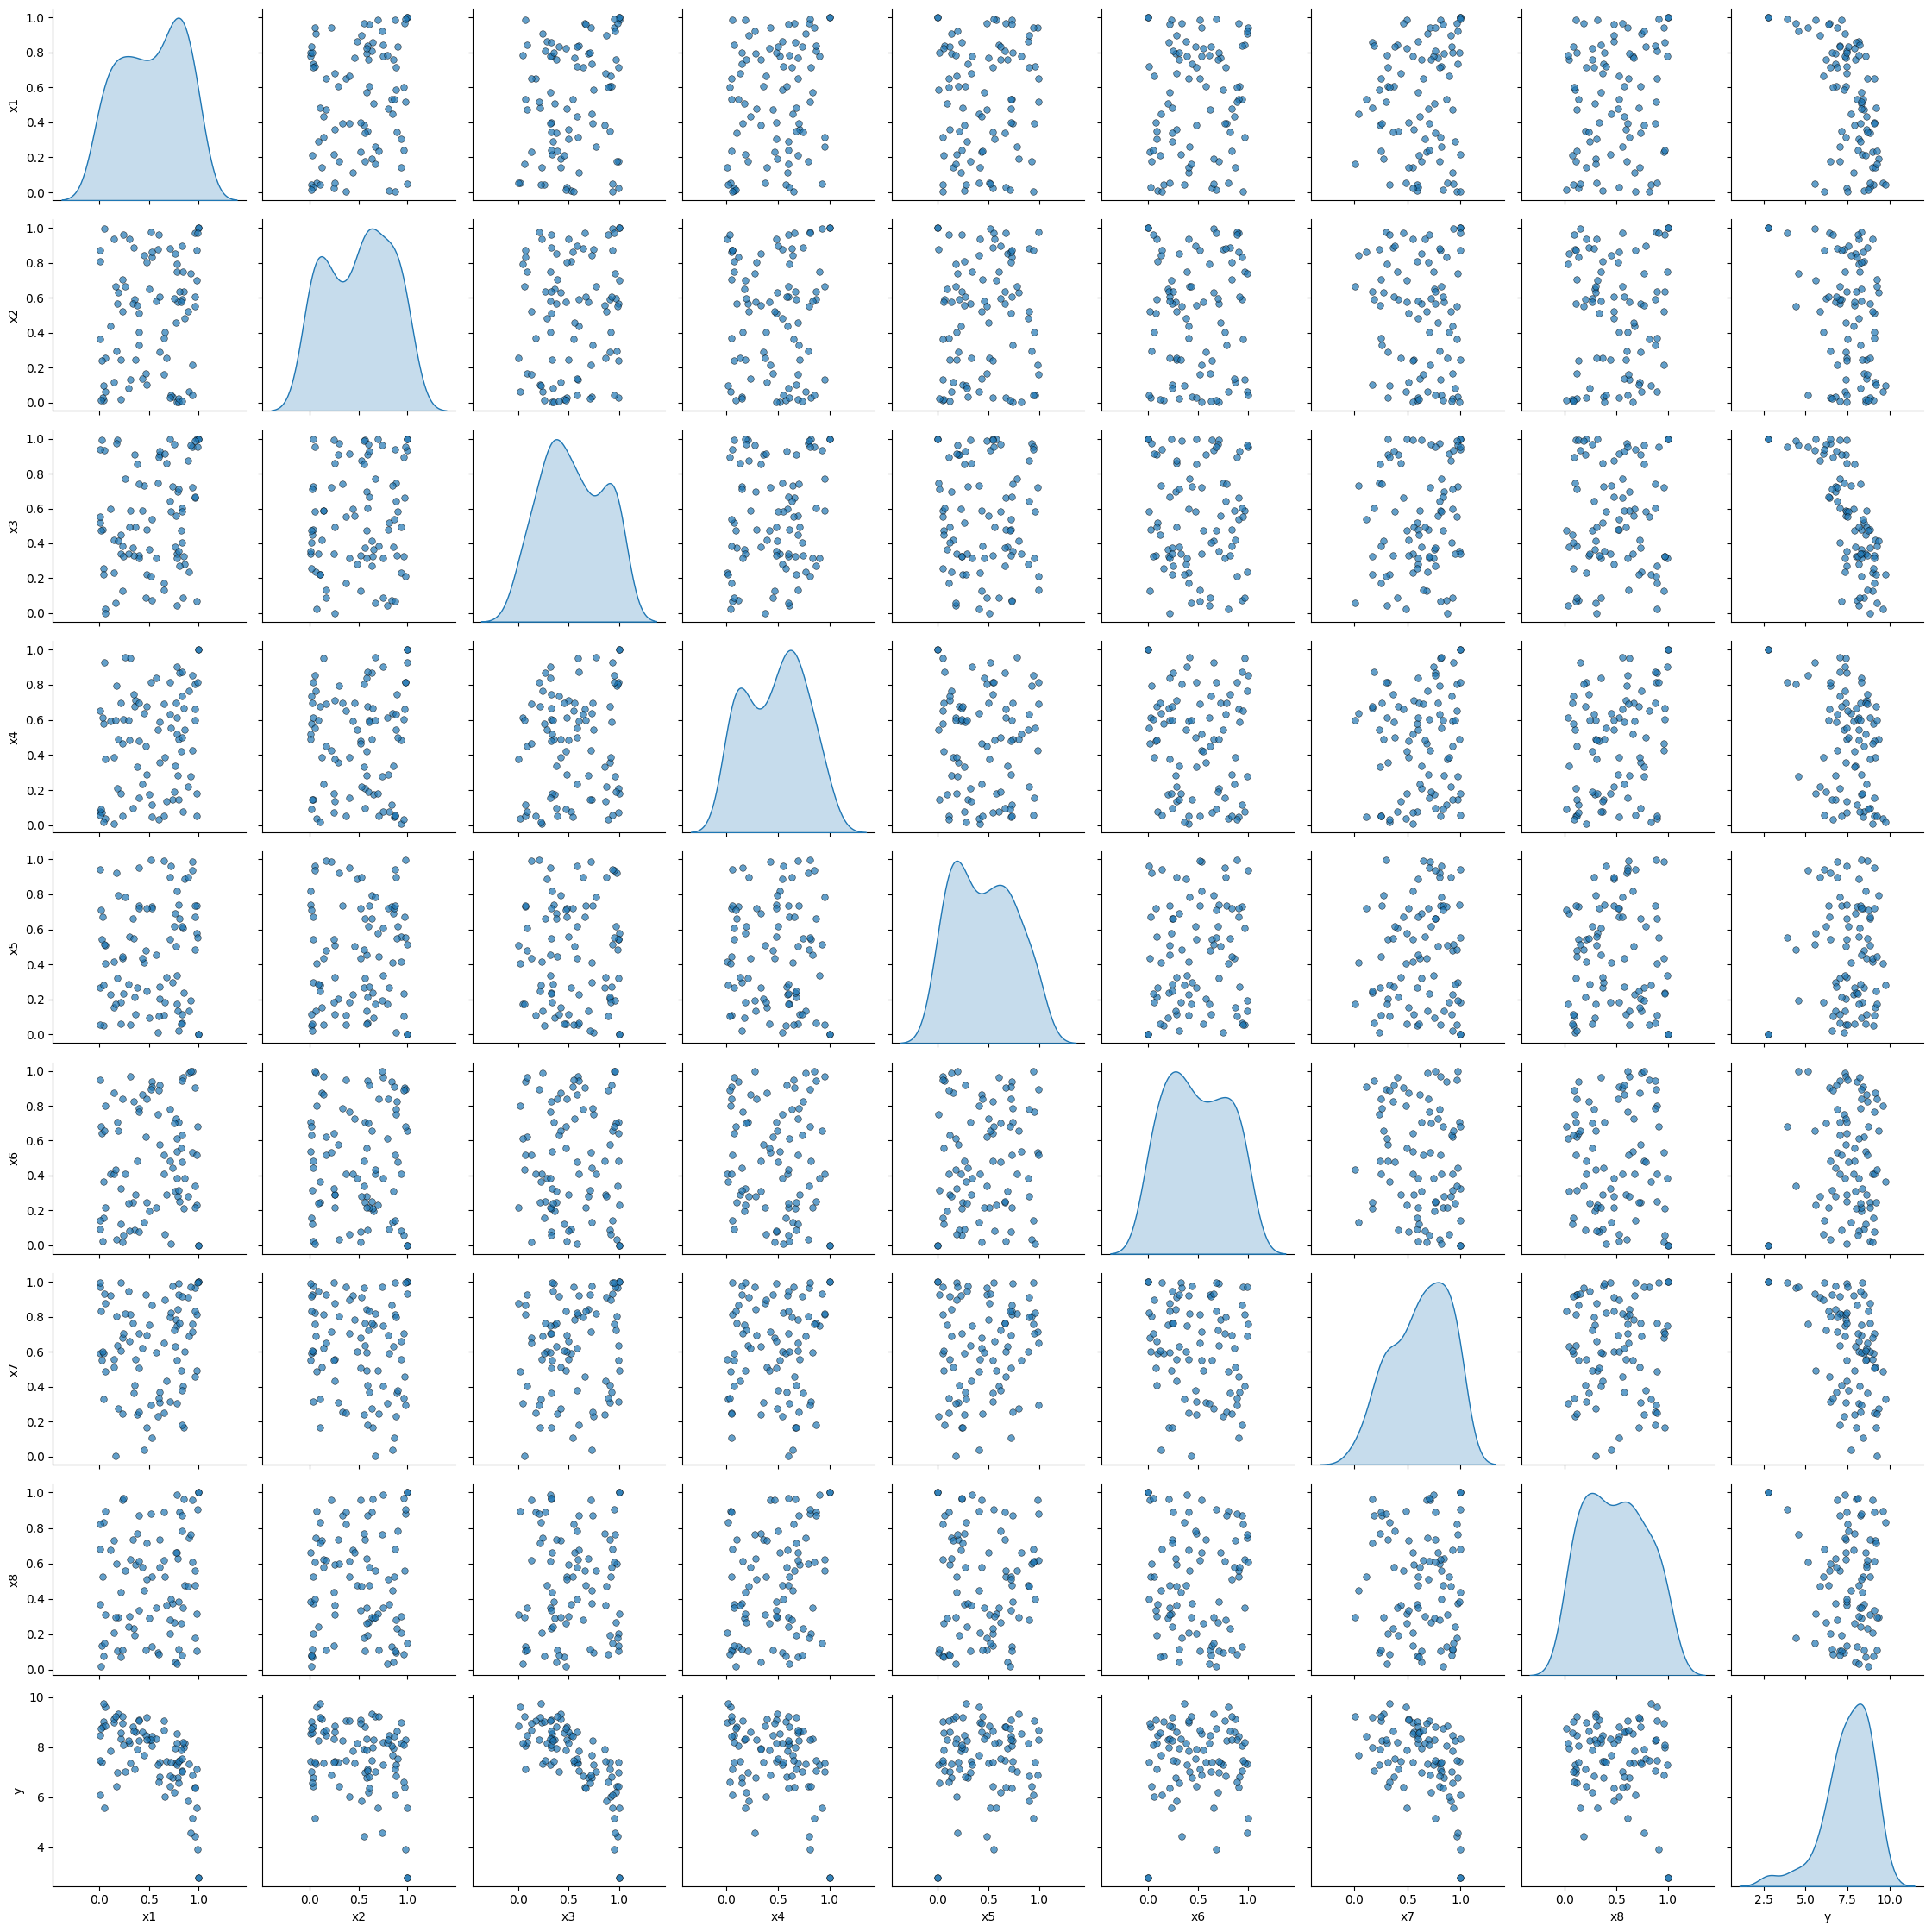

In [10]:
pairwise_relationship(df)

In [11]:
def objective_fn(x):
    return -(np.array([x[:, 0] + x[:, 1] + x[:, 2] + x[:, 3] + x[:, 4] + x[:, 5] + x[:, 6] + x[:, 7]]).T)

objective = GPyOpt.core.task.SingleObjective(objective_fn)

space = GPyOpt.Design_space(
    space=[{'name': 'x1', 'type': 'continuous', 'domain': (0, 0.999999)},
           {'name': 'x2', 'type': 'continuous', 'domain': (0, 0.999999)},
           {'name': 'x3', 'type': 'continuous', 'domain': (0, 0.999999)},
           {'name': 'x4', 'type': 'continuous', 'domain': (0, 0.999999)},
           {'name': 'x5', 'type': 'continuous', 'domain': (0, 0.999999)},
           {'name': 'x6', 'type': 'continuous', 'domain': (0, 0.999999)},
           {'name': 'x7', 'type': 'continuous', 'domain': (0, 0.999999)},
           {'name': 'x8', 'type': 'continuous', 'domain': (0, 0.999999)}]
)

gp_kernel = GPy.kern.Matern32(
    input_dim=8,
    variance=1.0,
    lengthscale=0.25,
    ARD=True
)

model = GPyOpt.models.GPModel(
    exact_feval=False,
    optimize_restarts=20,
    verbose=False,
    kernel=gp_kernel
)

acquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(space)

initial_design = GPyOpt.experiment_design.initial_design('random', space, 20)

acquisition = GPyOpt.acquisitions.AcquisitionEI(model, space, acquisition_optimizer, jitter=0.01)

evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

bo = GPyOpt.methods.ModularBayesianOptimization(
    model, space, objective, acquisition, evaluator,
    X_init=df[['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8']].values,
    Y_init=df['y'].values.reshape(-1, 1),
    de_duplication=True
)

In [12]:
bo.plot_acquisition()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [13]:
x_next = bo.suggest_next_locations()
print(f"next_query: {'-'.join(['%.6f' % x for x in x_next[0]])}")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
